<a href="https://colab.research.google.com/github/Dayoung-Jung/Prediction_of_Drug-Target_Interactions_Using_Graph_Neural_Network/blob/master/DTI_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 환경 셋팅**

In [ ]:
!mkdir -p /content/drive/My\ Drive/GraphDTA

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-geometric
!pip install rdkit-pypi -qqq
!pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.2 MB/s eta 0:00:00
  Created wheel for PyTDC: filename=PyTDC-0.4.1-py3-none-any.whl size=140643 sha256=94bd7d5e301f2c916e84ed79b7bafe3a53eda68d28d0cf1e7211d1a3930a2ad5
  Stored in directory: /root/.c

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import json,pickle
import networkx as nx
from math import sqrt
from random import shuffle
from collections import OrderedDict
from scipy import stats
from IPython.display import SVG
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import MolFromSmiles
from torch_geometric import data as DATA
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool as gmp
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_add_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# **1. 데이터 준비**

In [ ]:
from tdc.multi_pred import DTI

In [ ]:
# DAVIS 데이터셋 준비
data = DTI(name = 'DAVIS')
data.convert_to_log(form = 'binding')
split_DAVIS = data.get_split()

Downloading...
100%|██████████| 21.4M/21.4M [00:01<00:00, 14.5MiB/s]
Loading...
Done!
To log space...


In [ ]:
split_DAVIS['train'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,AAK1,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.365523
1,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL1p,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,4.999996
2,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ABL2,MVLGTVLLPPNSYGRDQDTSLCCLCTEASESALPDLTDHFASCVED...,4.999996
3,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR1,MVDGVMILPVLIMIALPSPSMEDEKPKVNPKLYMCVCEGLSCGNED...,4.999996
4,11314340,Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12,ACVR2A,MGAAAKLAFAVFLISCSSGAILGRSETQECLFFNANWEKDRTNQTG...,4.999996


In [ ]:
split_DAVIS['test'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,44150621,CC(O)C(=O)O.CN1CCN(c2ccc3c(c2)NC(=C2C(=O)N=c4c...,QSK,MPARIGYYEIDRTIGKGNFAVVKRATHLVTKAKVAIKIIDKTQLDE...,4.999996
1,10074640,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,IRAK1,MAGGPGPGEPAAPGAQHFLYEVPPWVMCRFYKVMDALEPADWCQFA...,4.999996
2,51004351,COC1C(N(C)C(=O)c2ccccc2)CC2OC1(C)n1c3ccccc3c3c...,CHEK2,MSRESDVEAQQSHGSSACSQPHGSVTQSQGSSSQSQGISSSSTSTM...,4.999996
3,9926054,Cc1ccc2nc(NCCN)c3ncc(C)n3c2c1.Cl,DAPK2,MFQASMRSPNMEPFKQQKVEDFYDIGEELGSGQFAIVKKCREKSTG...,4.999996
4,176155,CS(=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH...,TYRO3,MALRRSMGRPGLPPLPLPPPPRLGLLLAALASLLLPESAAAGLKLM...,4.999996


In [ ]:
split_DAVIS['valid'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,11667893,CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21,HCK,MGGRSSCEDPGCPRDEERAPRMGCMKSKFLQVGGNTFSKTETSASP...,5.065496
1,126565,CC12OC(CC1(O)CO)n1c3ccccc3c3c4c(c5c6ccccc6n2c5...,DYRK1A,MHTGGETSACKPSSVRLAPSFSFHAAGLQMAGQMPHSHQYSDRRQP...,7.696804
2,10113978,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,RIPK1,MQPDMSLNVIKMKSSDFLESAELDSGGFGKVSLCFHRTQGLMIMKT...,6.584860
3,10074640,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,NLK,MSLCGARANAKMMAAYNGGTSAAAAGHHHHHHHHLPHLPPPHLHHH...,4.999996
4,11338033,O=C(NC1CCNCC1)c1[nH]ncc1NC(=O)c1c(Cl)cccc1Cl,AURKB,MAQKENSYPWPYGRQTAPSGLSTLPQRVLRKEPVTPSALVLMSRSN...,4.999996


In [ ]:
# BindingDB 데이터셋 준비
data = DTI(name = 'BindingDB_Kd')
data.convert_to_log(form = 'binding')
split_BindingDB = data.get_split()

Downloading...
100%|██████████| 54.4M/54.4M [00:02<00:00, 20.1MiB/s]
Loading...
Done!
To log space...


In [ ]:
split_BindingDB['train'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,444607.0,Cc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.251812
1,4316.0,COc1ccc(CNS(=O)(=O)c2ccc(S(N)(=O)=O)s2)cc1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.229148
2,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.031517
3,4369102.0,CCN[C@H]1CN(CCOC)S(=O)(=O)c2sc(S(N)(=O)=O)cc21,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.376751
4,3013848.0,CN[C@H]1CN(c2cccc(OC)c2)S(=O)(=O)c2sc(S(N)(=O)...,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.698970


In [ ]:
split_BindingDB['test'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,9951964.0,O=C(c1ccc(F)cc1)C1CCN(CCC2Cc3cc(F)ccc3C2=O)CC1,P14842,MEILCEDNISLSSIPNSLMQLGDGPRLYHNDFNSRDANTSEASNWT...,8.114074
1,24889392.0,CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCC...,O14733,MAASSLEQKLSRLEAKLKQENREARRRIDLNLDISPQRPRPTLQLP...,4.999996
2,153999.0,CN(C)C[C@@H]1CCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)...,P33981,MESEDLSGRELTIDSIMNKVRDIKNKFKNEDLTDELSLNKISADTT...,4.999996
3,54756927.0,O=C(CCCCCNC(=O)COc1ccc(/C=C/c2ccc3n2[B-](F)(F)...,P07550,MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLA...,9.075044
4,44259.0,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,Q9P289,MAHSPVAVQVPGMQNNIADPEELFTKLERIGKGSFGEVFKGIDNRT...,6.853562


In [ ]:
split_BindingDB['valid'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,5287969.0,CN1CC[C@H](c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc...,Q15303,MKPATGLWVWVSLLVAAGTVQPSDSQSVCAGTENKLSSLSDLEQQY...,5.301021
1,11314340.0,Cc1n[nH]c2ccc(-c3cncc(OC[C@@H](N)Cc4ccccc4)c3)...,Q04759,MSPFLRIGLSNFDCGSCQSCQGEAVNPYCAVLVKEYVESENGQMYI...,7.917215
2,15462117.0,CN(C)C[C@@H](c1ccc2ccccc2c1)[C@@H](O)C(C)(C)C,P23975,MLLARMNPQVQPENNGADTGPEQPLRARKTAELLVVKERNGVQCLL...,7.521434
3,3038525.0,O=c1ncn2nc(Sc3ccc(F)cc3F)ccc2c1-c1c(Cl)cccc1Cl,P15056,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,8.958607
4,153999.0,CN(C)C[C@@H]1CCn2cc(c3ccccc32)C2=C(C(=O)NC2=O)...,P42680,MNFNTILEEILIKRSQQKKKTSPLNYKERLFVLTKSMLTYYEGRAE...,4.999996


In [ ]:
# KIBA 데이터셋 준비
data = DTI(name = 'KIBA')
data.convert_to_log(form = 'binding')
split_KIBA = data.get_split()

Downloading...
100%|██████████| 96.6M/96.6M [00:04<00:00, 22.7MiB/s]
Loading...
Done!
To log space...


In [ ]:
split_KIBA['train'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,7.950782
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P04626,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,7.950782
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P06239,MGCGCSSHPEDDWMENIDVCENCHYPIVPLDGKGTLLIRNGSEVRD...,7.950782
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P15056,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,7.950782
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P24941,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,7.950782


In [ ]:
split_KIBA['test'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1991725,CN(C)CC(=O)NC(COc1cncc(-c2ccc3cnccc3c2)c1)Cc1c...,P15735,MTLDVGPEDELPDWAAAKEFYQKYDPKDVIGRGVSSVVRRCVHRAT...,7.939302
1,CHEMBL202635,COc1cc(CN2CCCCC2)c(Cl)cc1NC(=O)Nc1cnc(C#N)cn1,P35916,MQRGAALCLRLWLCLGLLDGLVSGYSMTPPTLNITEESHVIDTGDS...,7.931814
2,CHEMBL2007296,CCCOc1cccc(C(C)NC(=O)c2ccc(-c3ccncc3)cc2)c1,Q96PF2,MDDATVLRKKGYIVGINLGKGSYAKVKSAYSERLKFNVAVKIIDRK...,7.920819
3,CHEMBL293750,COC1C(N(C)C)CC2OC1(C)n1c3ccccc3c3c4c(c5c6ccccc...,Q05655,MAPFLRIAFNSYELGSLQAEDEANQPFCAVKMKEALSTERGKTLVQ...,7.980808
4,CHEMBL2001477,NC(=O)c1ccc(-c2ccncc2)cc1NCc1ccccc1,P49841,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,7.920819


In [ ]:
split_KIBA['valid'].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1990912,OCCNc1cc2cc(-c3cccnc3)ccc2cn1,Q13976,MSELEEDFAKILMLKEERIKELEKRLSEKEEEIQELKRKLHKCQSV...,7.924453
1,CHEMBL2006481,O=C(c1cc(-c2ccc3[nH]ncc3c2)on1)N1CCCCC1,P49841,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,7.943095
2,CHEMBL1967560,CCN1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc...,P49137,MLSNSQGQSPPVPFPAPAPPPQPPTPALPHPPAQPPPPPPQQFPQF...,7.946922
3,CHEMBL402548,COC(C(=O)N1Cc2[nH]nc(NC(=O)c3ccc(N4CCN(C)CC4)c...,O43781,MGGTARGPGRKDAGPPGAGLPPQQRRLGDGVYDTFMMIDETKCPPC...,7.943095
4,CHEMBL1983195,CCN(CC)C(=O)Nc1ccc2nc(-c3ccco3)c(-c3ccco3)nc2c1,O96017,MSRESDVEAQQSHGSSACSQPHGSVTQSQGSSSQSQGISSSSTSTM...,7.920819


# **2. Drug(약물) & Target(단백질) 필요한 함수**

## **2-1. 분자 구조 시각화**

In [ ]:
def moltosvg(mol,molSize=(600,400),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

In [ ]:
def render_svg(svg):
    return SVG(svg.replace('svg:',''))

In [ ]:
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

In [ ]:
def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [ ]:
def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

스마일즈로 표현된 분자:  Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12
원자 수:  27


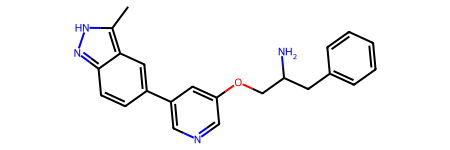

In [ ]:
example_DAVIS = split_DAVIS['train']['Drug'][0]
example_mol = Chem.MolFromSmiles(example_DAVIS)
render_svg(moltosvg(example_mol))

print("스마일즈로 표현된 분자: ", example_DAVIS)
print("원자 수: ", len(example_mol.GetAtoms()))

example_mol

## **2-2. 분자 구조를 그래프로 변환**

In [ ]:
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    c_size = mol.GetNumAtoms()

    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])

    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])

    return c_size, features, edge_index

## **2-3. Target(단백질) 라벨 인코딩**

In [ ]:
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000

def seq_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]):
        x[i] = seq_dict[ch]

    return x

# **3. 그래프 데이터셋 만들기**

## **3-1. 필요한 함수 준비**

In [ ]:
Drug_list = []

opts = ['train','test', 'valid']

for opt in opts:
    Drug_list += list(split_DAVIS[opt]['Drug'])
    Drug_list += list(split_BindingDB[opt]['Drug'])
    Drug_list += list(split_KIBA[opt]['Drug'])

Drug_list = set(Drug_list)
Drug_graph = {}

for drug in Drug_list:
    g = smile_to_graph(drug)
    Drug_graph[drug] = g

In [ ]:
class TestbedDataset(InMemoryDataset):
    def __init__(self, root='/tmp', dataset='davis',
                 xd=None, xt=None, y=None, transform=None,
                 pre_transform=None,smile_graph=None):

        super(TestbedDataset, self).__init__(root, transform, pre_transform)
        self.dataset = dataset
        if os.path.isfile(self.processed_paths[0]):
            print('Pre-processed data found: {}, loading ...'.format(self.processed_paths[0]))
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            print('Pre-processed data {} not found, doing pre-processing...'.format(self.processed_paths[0]))
            self.process(xd, xt, y,smile_graph)
            self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        pass

    @property
    def processed_file_names(self):
        return [self.dataset + '.pt']

    def download(self):
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)

    def process(self, xd, xt, y,smile_graph):
        assert (len(xd) == len(xt) and len(xt) == len(y)), "The three lists must be the same length!"
        data_list = []
        data_len = len(xd)

        for i in range(data_len):
            print('Converting SMILES to graph: {}/{}'.format(i+1, data_len))
            smiles = xd[i]
            target = xt[i]
            labels = y[i]

            c_size, features, edge_index = smile_graph[smiles]
            GCNData = DATA.Data(x=torch.Tensor(features),
                                edge_index=torch.LongTensor(edge_index).transpose(1, 0),
                                y=torch.FloatTensor([labels]))
            GCNData.target = torch.LongTensor([target])
            GCNData.__setitem__('c_size', torch.LongTensor([c_size]))
            data_list.append(GCNData)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        print('Graph construction done. Saving to file.')
        data, slices = self.collate(data_list)

        torch.save((data, slices), self.processed_paths[0])

## **3-2. DAVIS 그래프 데이터셋**

In [ ]:
train_drugs, train_prots, train_Y = list(split_DAVIS['train']['Drug']), list(split_DAVIS['train']['Target']), list(split_DAVIS['train']['Y'])
XT = [seq_cat(t) for t in train_prots]
train_drugs, train_prots, train_Y = np.asarray(train_drugs), np.asarray(XT), np.asarray(train_Y)

test_drugs, test_prots, test_Y = list(split_DAVIS['test']['Drug']), list(split_DAVIS['test']['Target']), list(split_DAVIS['test']['Y'])
XT = [seq_cat(t) for t in test_prots]
test_drugs, test_prots, test_Y = np.asarray(test_drugs), np.asarray(XT), np.asarray(test_Y)

valid_drugs, valid_prots, valid_Y = list(split_DAVIS['valid']['Drug']), list(split_DAVIS['valid']['Target']), list(split_DAVIS['valid']['Y'])
XT = [seq_cat(t) for t in valid_prots]
valid_drugs, valid_prots, valid_Y = np.asarray(valid_drugs), np.asarray(XT), np.asarray(valid_Y)


print('preparing ', 'DAVIS' + '_train.pt in pytorch format!')
train_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='DAVIS'+'_train', xd=train_drugs, xt=train_prots, y=train_Y,smile_graph=Drug_graph)
print('preparing ', 'DAVIS' + '_test.pt in pytorch format!')
test_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='DAVIS'+'_test', xd=test_drugs, xt=test_prots, y=test_Y,smile_graph=Drug_graph)
print('preparing ', 'DAVIS' + '_valid.pt in pytorch format!')
valid_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='DAVIS'+'_valid', xd=valid_drugs, xt=valid_prots, y=valid_Y,smile_graph=Drug_graph)
print('DAVIS Dataset have been created')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Converting SMILES to graph: 2737/5154
Converting SMILES to graph: 2738/5154
Converting SMILES to graph: 2739/5154
Converting SMILES to graph: 2740/5154
Converting SMILES to graph: 2741/5154
Converting SMILES to graph: 2742/5154
Converting SMILES to graph: 2743/5154
Converting SMILES to graph: 2744/5154
Converting SMILES to graph: 2745/5154
Converting SMILES to graph: 2746/5154
Converting SMILES to graph: 2747/5154
Converting SMILES to graph: 2748/5154
Converting SMILES to graph: 2749/5154
Converting SMILES to graph: 2750/5154
Converting SMILES to graph: 2751/5154
Converting SMILES to graph: 2752/5154
Converting SMILES to graph: 2753/5154
Converting SMILES to graph: 2754/5154
Converting SMILES to graph: 2755/5154
Converting SMILES to graph: 2756/5154
Converting SMILES to graph: 2757/5154
Converting SMILES to graph: 2758/5154
Converting SMILES to graph: 2759/5154
Converting SMILES to graph: 2760/5154
Converting SMILES to graph: 2761/5154
Converting SMI

## **3-3. BindingDB 그래프 데이터셋**

In [ ]:
train_drugs, train_prots, train_Y = list(split_BindingDB['train']['Drug']), list(split_BindingDB['train']['Target']), list(split_BindingDB['train']['Y'])
XT = [seq_cat(t) for t in train_prots]
train_drugs, train_prots, train_Y = np.asarray(train_drugs), np.asarray(XT), np.asarray(train_Y)

test_drugs, test_prots, test_Y = list(split_BindingDB['test']['Drug']), list(split_BindingDB['test']['Target']), list(split_BindingDB['test']['Y'])
XT = [seq_cat(t) for t in test_prots]
test_drugs, test_prots, test_Y = np.asarray(test_drugs), np.asarray(XT), np.asarray(test_Y)

valid_drugs, valid_prots, valid_Y = list(split_BindingDB['valid']['Drug']), list(split_BindingDB['valid']['Target']), list(split_BindingDB['valid']['Y'])
XT = [seq_cat(t) for t in valid_prots]
valid_drugs, valid_prots, valid_Y = np.asarray(valid_drugs), np.asarray(XT), np.asarray(valid_Y)


print('preparing ', 'BindingDB' + '_train.pt in pytorch format!')
train_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='BindingDB'+'_train', xd=train_drugs, xt=train_prots, y=train_Y,smile_graph=Drug_graph)
print('preparing ', 'BindingDB' + '_test.pt in pytorch format!')
test_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='BindingDB'+'_test', xd=test_drugs, xt=test_prots, y=test_Y,smile_graph=Drug_graph)
print('preparing ', 'BindingDB' + '_valid.pt in pytorch format!')
valid_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='BindingDB'+'_valid', xd=valid_drugs, xt=valid_prots, y=valid_Y,smile_graph=Drug_graph)
print('BindingDB Dataset have been created')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Converting SMILES to graph: 230/5227
Converting SMILES to graph: 231/5227
Converting SMILES to graph: 232/5227
Converting SMILES to graph: 233/5227
Converting SMILES to graph: 234/5227
Converting SMILES to graph: 235/5227
Converting SMILES to graph: 236/5227
Converting SMILES to graph: 237/5227
Converting SMILES to graph: 238/5227
Converting SMILES to graph: 239/5227
Converting SMILES to graph: 240/5227
Converting SMILES to graph: 241/5227
Converting SMILES to graph: 242/5227
Converting SMILES to graph: 243/5227
Converting SMILES to graph: 244/5227
Converting SMILES to graph: 245/5227
Converting SMILES to graph: 246/5227
Converting SMILES to graph: 247/5227
Converting SMILES to graph: 248/5227
Converting SMILES to graph: 249/5227
Converting SMILES to graph: 250/5227
Converting SMILES to graph: 251/5227
Converting SMILES to graph: 252/5227
Converting SMILES to graph: 253/5227
Converting SMILES to graph: 254/5227
Converting SMILES to graph: 255/5227
Co

## **3-4. KIBA 그래프 데이터셋**

In [ ]:
train_drugs, train_prots, train_Y = list(split_KIBA['train']['Drug']), list(split_KIBA['train']['Target']), list(split_KIBA['train']['Y'])
XT = [seq_cat(t) for t in train_prots]
train_drugs, train_prots, train_Y = np.asarray(train_drugs), np.asarray(XT), np.asarray(train_Y)

test_drugs, test_prots, test_Y = list(split_KIBA['test']['Drug']), list(split_KIBA['test']['Target']), list(split_KIBA['test']['Y'])
XT = [seq_cat(t) for t in test_prots]
test_drugs, test_prots, test_Y = np.asarray(test_drugs), np.asarray(XT), np.asarray(test_Y)

valid_drugs, valid_prots, valid_Y = list(split_KIBA['valid']['Drug']), list(split_KIBA['valid']['Target']), list(split_KIBA['valid']['Y'])
XT = [seq_cat(t) for t in valid_prots]
valid_drugs, valid_prots, valid_Y = np.asarray(valid_drugs), np.asarray(XT), np.asarray(valid_Y)


print('preparing ', 'KIBA' + '_train.pt in pytorch format!')
train_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='KIBA'+'_train', xd=train_drugs, xt=train_prots, y=train_Y,smile_graph=Drug_graph)
print('preparing ', 'KIBA' + '_test.pt in pytorch format!')
test_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='KIBA'+'_test', xd=test_drugs, xt=test_prots, y=test_Y,smile_graph=Drug_graph)
print('preparing ', 'KIBA' + '_valid.pt in pytorch format!')
valid_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset='KIBA'+'_valid', xd=valid_drugs, xt=valid_prots, y=valid_Y,smile_graph=Drug_graph)
print('KIBA Dataset have been created')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Converting SMILES to graph: 6769/11766
Converting SMILES to graph: 6770/11766
Converting SMILES to graph: 6771/11766
Converting SMILES to graph: 6772/11766
Converting SMILES to graph: 6773/11766
Converting SMILES to graph: 6774/11766
Converting SMILES to graph: 6775/11766
Converting SMILES to graph: 6776/11766
Converting SMILES to graph: 6777/11766
Converting SMILES to graph: 6778/11766
Converting SMILES to graph: 6779/11766
Converting SMILES to graph: 6780/11766
Converting SMILES to graph: 6781/11766
Converting SMILES to graph: 6782/11766
Converting SMILES to graph: 6783/11766
Converting SMILES to graph: 6784/11766
Converting SMILES to graph: 6785/11766
Converting SMILES to graph: 6786/11766
Converting SMILES to graph: 6787/11766
Converting SMILES to graph: 6788/11766
Converting SMILES to graph: 6789/11766
Converting SMILES to graph: 6790/11766
Converting SMILES to graph: 6791/11766
Converting SMILES to graph: 6792/11766
Converting SMILES to graph: 

# **4. 평가지표**

In [ ]:
def mse(y,f):
    mse = ((y - f)**2).mean(axis=0)
    return mse

In [ ]:
def rmse(y,f):
    rmse = sqrt(((y - f)**2).mean(axis=0))
    return rmse

In [ ]:
def pearson(y,f):
    rp = np.corrcoef(y, f)[0,1]
    return rp

In [ ]:
def spearman(y,f):
    rs = stats.spearmanr(y, f)[0]
    return rs

In [ ]:
def ci(y,f):
    ind = np.argsort(y)
    y = y[ind]
    f = f[ind]
    i = len(y)-1
    j = i-1
    z = 0.0
    S = 0.0
    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z+1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i-1
    ci = S/z
    return ci

# **5. 학습 모델**

## **5-1. GCN**

In [ ]:
class GCNNet(torch.nn.Module):
    def __init__(self, n_output=1, n_filters=32, embed_dim=128,num_features_xd=78, num_features_xt=25, output_dim=128, dropout=0.2):

        super(GCNNet, self).__init__()
        self.n_output = n_output
        self.conv1 = GCNConv(num_features_xd, num_features_xd)
        self.conv2 = GCNConv(num_features_xd, num_features_xd*2)
        self.conv3 = GCNConv(num_features_xd*2, num_features_xd * 4)
        self.fc_g1 = torch.nn.Linear(num_features_xd*4, 1024)
        self.fc_g2 = torch.nn.Linear(1024, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.embedding_xt = nn.Embedding(num_features_xt + 1, embed_dim)
        self.conv_xt_1 = nn.Conv1d(in_channels=1000, out_channels=n_filters, kernel_size=8)
        self.fc1_xt = nn.Linear(32*121, output_dim)
        self.fc1 = nn.Linear(2*output_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, self.n_output)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        target = data.target
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.conv3(x, edge_index)
        x = self.relu(x)
        x = gmp(x, batch)
        x = self.relu(self.fc_g1(x))
        x = self.dropout(x)
        x = self.fc_g2(x)
        x = self.dropout(x)
        embedded_xt = self.embedding_xt(target)
        conv_xt = self.conv_xt_1(embedded_xt)
        xt = conv_xt.view(-1, 32 * 121)
        xt = self.fc1_xt(xt)
        xc = torch.cat((x, xt), 1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

## **5-2. GAT**

In [ ]:
class GATNet(torch.nn.Module):
    def __init__(self, num_features_xd=78, n_output=1, num_features_xt=25,
                     n_filters=32, embed_dim=128, output_dim=128, dropout=0.2):
        super(GATNet, self).__init__()
        self.gcn1 = GATConv(num_features_xd, num_features_xd, heads=10, dropout=dropout)
        self.gcn2 = GATConv(num_features_xd * 10, output_dim, dropout=dropout)
        self.fc_g1 = nn.Linear(output_dim, output_dim)
        self.embedding_xt = nn.Embedding(num_features_xt + 1, embed_dim)
        self.conv_xt1 = nn.Conv1d(in_channels=1000, out_channels=n_filters, kernel_size=8)
        self.fc_xt1 = nn.Linear(32*121, output_dim)
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.out = nn.Linear(256, n_output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.gcn1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.gcn2(x, edge_index)
        x = self.relu(x)
        x = gmp(x, batch)
        x = self.fc_g1(x)
        x = self.relu(x)
        target = data.target
        embedded_xt = self.embedding_xt(target)
        conv_xt = self.conv_xt1(embedded_xt)
        conv_xt = self.relu(conv_xt)
        xt = conv_xt.view(-1, 32 * 121)
        xt = self.fc_xt1(xt)
        xc = torch.cat((x, xt), 1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

## **5-3. GAT_GCN**

In [ ]:
class GAT_GCN(torch.nn.Module):
    def __init__(self, n_output=1, num_features_xd=78, num_features_xt=25,
                 n_filters=32, embed_dim=128, output_dim=128, dropout=0.2):

        super(GAT_GCN, self).__init__()
        self.n_output = n_output
        self.conv1 = GATConv(num_features_xd, num_features_xd, heads=10)
        self.conv2 = GCNConv(num_features_xd*10, num_features_xd*10)
        self.fc_g1 = torch.nn.Linear(num_features_xd*10*2, 1500)
        self.fc_g2 = torch.nn.Linear(1500, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.embedding_xt = nn.Embedding(num_features_xt + 1, embed_dim)
        self.conv_xt_1 = nn.Conv1d(in_channels=1000, out_channels=n_filters, kernel_size=8)
        self.fc1_xt = nn.Linear(32*121, output_dim)
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, self.n_output)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        target = data.target
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
        x = self.relu(self.fc_g1(x))
        x = self.dropout(x)
        x = self.fc_g2(x)
        embedded_xt = self.embedding_xt(target)
        conv_xt = self.conv_xt_1(embedded_xt)
        xt = conv_xt.view(-1, 32 * 121)
        xt = self.fc1_xt(xt)
        xc = torch.cat((x, xt), 1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

## **5-4. GIN**

In [ ]:
class GINConvNet(torch.nn.Module):
    def __init__(self, n_output=1,num_features_xd=78, num_features_xt=25,
                 n_filters=32, embed_dim=128, output_dim=128, dropout=0.2):

        super(GINConvNet, self).__init__()

        dim = 32

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.n_output = n_output
        nn1 = Sequential(Linear(num_features_xd, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1_xd = Linear(dim, output_dim)

        self.embedding_xt = nn.Embedding(num_features_xt + 1, embed_dim)
        self.conv_xt_1 = nn.Conv1d(in_channels=1000, out_channels=n_filters, kernel_size=8)
        self.fc1_xt = nn.Linear(32*121, output_dim)

        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.out = nn.Linear(256, self.n_output)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        target = data.target

        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1_xd(x))
        x = F.dropout(x, p=0.2, training=self.training)

        embedded_xt = self.embedding_xt(target)
        conv_xt = self.conv_xt_1(embedded_xt)
        xt = conv_xt.view(-1, 32 * 121)
        xt = self.fc1_xt(xt)
        xc = torch.cat((x, xt), 1)
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

# **6. 학습 진행**

## **6-1. traing 함수**

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data.x),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

## **6-2. predict 함수**

In [ ]:
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()

    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)

    return total_labels.numpy().flatten(),total_preds.numpy().flatten()

## **6-3. 모델 학습 진행**

In [ ]:
datasets = ['DAVIS', 'BindingDB', 'KIBA']
modeling = [GINConvNet, GATNet, GAT_GCN, GCNNet]
cuda_name = "cuda:0"

In [ ]:
TRAIN_BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LR = 0.0005
LOG_INTERVAL = 20
NUM_EPOCHS = 10

In [ ]:
# for d in datasets:
#   for m in modeling:
#       train_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset = d+'_train')
#       test_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset = d+'_test')

#       train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
#       test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

#       device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")
#       model = m().to(device)

#       loss_fn = nn.MSELoss()
#       optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#       best_mse = 10004
#       best_ci = 0
#       best_epoch = -1

#       model_file_name = 'model_' + m.__name__ + '_' + d +  '.model'
#       result_file_name = 'result_' + m.__name__ + '_' + d +  '.csv'

#       for epoch in range(NUM_EPOCHS):
#           train(model, device, train_loader, optimizer, epoch+1)

#           G,P = predicting(model, device, test_loader)
#           ret = [rmse(G,P),mse(G,P),pearson(G,P),spearman(G,P),ci(G,P)]

#           if ret[1]<best_mse:
#               torch.save(model.state_dict(), model_file_name)
#               with open(result_file_name,'w') as f:
#                   f.write(','.join(map(str,ret)))
#               best_epoch = epoch+1
#               best_mse = ret[1]
#               best_ci = ret[-1]
#               print('rmse improved at epoch ', best_epoch, '; best_mse,best_ci:', best_mse, best_ci, m, d)
#           else:
#               print(ret[1],'No improvement since epoch ', best_epoch, '; best_mse,best_ci:', best_mse, best_ci, m, d)

Pre-processed data found: /content/drive/My Drive/GraphDTA/data/processed/DAVIS_train.pt, loading ...
Pre-processed data found: /content/drive/My Drive/GraphDTA/data/processed/DAVIS_test.pt, loading ...
Training on 18041 samples...
Train epoch: 1 [0/18041 (0%)]	Loss: 29.830723
Make prediction for 5154 samples...
rmse improved at epoch  1 ; best_mse,best_ci: 1.1029257 0.5995786286191563 <class '__main__.GINConvNet'> DAVIS
Training on 18041 samples...
Train epoch: 2 [0/18041 (0%)]	Loss: 0.963416
Make prediction for 5154 samples...
1.9148939 No improvement since epoch  1 ; best_mse,best_ci: 1.1029257 0.5995786286191563 <class '__main__.GINConvNet'> DAVIS
Training on 18041 samples...
Train epoch: 3 [0/18041 (0%)]	Loss: 0.703781
Make prediction for 5154 samples...
1.5299127 No improvement since epoch  1 ; best_mse,best_ci: 1.1029257 0.5995786286191563 <class '__main__.GINConvNet'> DAVIS
Training on 18041 samples...
Train epoch: 4 [0/18041 (0%)]	Loss: 0.628446
Make prediction for 5154 sample

# **7. 학습된 모델로 예측 진행**

## **7-1. Predict 함수**

In [ ]:
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()

## **7-2. Predict 진행**

In [ ]:
datasets = ['DAVIS', 'BindingDB', 'KIBA']
modelings = [GINConvNet, GATNet, GAT_GCN, GCNNet]
cuda_name = "cuda:0"

In [ ]:
TEST_BATCH_SIZE = 1024

In [ ]:
# result = []
# y_pred_array = []

# for dataset in datasets :
#     processed_data_file_test = '/content/drive/My Drive/GraphDTA/data/processed/' + dataset + '_test.pt'

#     if (not os.path.isfile(processed_data_file_test)):
#         print('please run create_data.py to prepare data in pytorch format!')
#     else:
#         test_data = TestbedDataset(root='/content/drive/My Drive/GraphDTA/data', dataset=dataset+'_test')
#         test_loader = DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False)

#         for modeling in modelings :
#             model_st = modeling.__name__
#             print('\npredicting for ', dataset, ' using ', model_st)

#             # training the model
#             device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")
#             model = modeling().to(device)
#             model_file_name = '/content/model_' + model_st + '_' + dataset +  '.model'

#             if os.path.isfile(model_file_name):
#                 model.load_state_dict(torch.load(model_file_name, map_location=cuda_name), strict=False)
#                 G,P = predicting(model, device, test_loader)
#                 y_pred_array.append(G)
#                 y_pred_array.append(P)
#                 ret = [rmse(G,P),mse(G,P),pearson(G,P),spearman(G,P),ci(G,P)]
#                 ret =[dataset, model_st] +  [round(e,3) for e in ret]
#                 result += [ ret ]
#                 print('dataset,model,rmse,mse,pearson,spearman,ci')
#                 print(ret)
#             else:
#                 print('model is not available!')

#     print('\n')

Pre-processed data found: /content/drive/My Drive/GraphDTA/data/processed/DAVIS_test.pt, loading ...

predicting for  DAVIS  using  GINConvNet
Make prediction for 5154 samples...
dataset,model,rmse,mse,pearson,spearman,ci
['DAVIS', 'GINConvNet', 0.659, 0.434, 0.617, 0.529, 0.799]

predicting for  DAVIS  using  GATNet
Make prediction for 5154 samples...
dataset,model,rmse,mse,pearson,spearman,ci
['DAVIS', 'GATNet', 0.74, 0.547, 0.434, 0.406, 0.726]

predicting for  DAVIS  using  GAT_GCN
Make prediction for 5154 samples...
dataset,model,rmse,mse,pearson,spearman,ci
['DAVIS', 'GAT_GCN', 0.682, 0.465, 0.541, 0.491, 0.775]

predicting for  DAVIS  using  GCNNet
Make prediction for 5154 samples...
dataset,model,rmse,mse,pearson,spearman,ci
['DAVIS', 'GCNNet', 0.677, 0.459, 0.549, 0.497, 0.778]


Pre-processed data found: /content/drive/My Drive/GraphDTA/data/processed/BindingDB_test.pt, loading ...

predicting for  BindingDB  using  GINConvNet
Make prediction for 10455 samples...
dataset,mode

In [ ]:
with open('/content/drive/My Drive/GraphDTA/result.csv','w') as f:
    f.write('dataset,model,rmse,mse,pearson,spearman,ci\n')

    for ret in result:
        f.write(','.join(map(str,ret)) + '\n')

# **8. 결과**

In [ ]:
result_df = pd.read_csv('/content/drive/My Drive/GraphDTA/result.csv')
result_df

,dataset,model,rmse,mse,pearson,spearman,ci
0,DAVIS,GINConvNet,0.659,0.434,0.617,0.529,0.799
1,DAVIS,GATNet,0.740,0.547,0.434,0.406,0.726
2,DAVIS,GAT_GCN,0.682,0.465,0.541,0.491,0.775
3,DAVIS,GCNNet,0.677,0.459,0.549,0.497,0.778
4,BindingDB,GINConvNet,0.997,0.994,0.685,0.663,0.776
5,BindingDB,GATNet,1.078,1.162,0.616,0.586,0.740
6,BindingDB,GAT_GCN,1.028,1.058,0.670,0.652,0.770
7,BindingDB,GCNNet,1.043,1.088,0.654,0.632,0.760
8,KIBA,GINConvNet,0.102,0.010,0.055,0.069,0.524
9,KIBA,GATNet,0.060,0.004,0.102,0.130,0.546
